# Versions Python et Libraries

In [44]:
!python --version

Python 3.11.5


In [75]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import shutil

In [46]:
# Modélisation CNN avec tensorflow
import tensorflow as tf
import tensorflow.keras.layers as tfl

# Gestion des images : lecture, transformations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

# Gestion de l'architecture du réseau
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Flatten, Conv2D, Activation, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D # type: ignore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing, Rescaling, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

# Architecture de modèles de réseaux pré-entrainés (fonctionnalité de Transfer Learning)
from tensorflow.keras.applications import MobileNetV2, VGG16

# Algorithme d'optimisation
from tensorflow.keras.optimizers.legacy import RMSprop, Adam

# Sauvegarde, arret
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# Open CV
import cv2

# Performances des modeles
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.utils.multiclass import unique_labels

# Constantes

In [47]:
# chemin des 2 dossiers d'images par classe à prédire pour l'apprentissage et l'évaluation des performances et l'inférence
SRC_PATH_TRAIN = "./dataset_footprint/train/"
SRC_PATH_TEST = "./dataset_footprint/test/"

# Liste des catégories (classes à prévoir)
LST_LABELS = os.listdir(SRC_PATH_TRAIN)

# Parametres pour la generation d'images
SEED_VALUE = 42
VALID_SIZE = 0.2

In [48]:
IMG_SIZE = 160  # Taille de l'image IMG_SIZExIMG_SIZE (on augmente la resolution de 100 a 160)
BATCH_SIZE = 10  # nb de données à passer pour un A/R dans le réseau (total de 77 images x 3 classes)
NB_EPOCHS = 30  # Nb de passes

In [49]:
# Définition comme label les noms des sous-dossiers de travail
labels = os.listdir(SRC_PATH_TRAIN)
LST_DIR_LABELS = labels
LST_DIR_LABELS

['Castor',
 'Chat',
 'Chien',
 'Coyote',
 'Ecureuil',
 'Lapin',
 'Loup',
 'Lynx',
 'Ours',
 'Puma',
 'Rat',
 'RatonLaveur',
 'Renard']

In [50]:
# Sauvegarde du modèle optimal (nom et sous-dossier)
CKPT_NO, MDL_NAME = 'ckpt_footprints_1', '3footprints_CNN'
CKPT_DIR = './'+ CKPT_NO
PATH_BEST_MDL = CKPT_DIR + '/' + MDL_NAME

# Fonctions Locales

## Graphs

In [51]:
def plot_learning_curve(history):
    """
    Fonction de tracé de la courbe d'ajustement d'un modèle
    Arguments:
        history : sequence de recueil des métriques d'évaluation d'un modèle lors de la phase d'apprentissage
        les métriques sont ici prédéfinies : 'accuracy','val_accuracy','loss','val_loss'
    Returns:
        2 figures Matplotlib superposées des métriques 'accuracy' et 'loss' sur les datasets TRAIN et VALIDATION
    """
    # Définition des séquences de sauvegarde des performances en TRAIN (accuracy et loss) et VALIDATION (val_)
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # Liste des itérations de calcul : epochs
    lst_epochs = range(len(accuracy))

    # Tracé en 2 figures
    plt.figure(figsize=(20,6))
    plt.plot(lst_epochs, accuracy, "b", label="accuracy [TRAIN]")
    plt.plot(lst_epochs, val_accuracy, "r", label="accuracy [VALIDATION]")
    plt.title("Exactitude du modèle")
    plt.legend()
    plt.show()

    plt.figure(figsize=(20,6))
    plt.plot(lst_epochs, loss, "b", label="loss [TRAIN]")
    plt.plot(lst_epochs, val_loss, "r", label="loss [VALIDATION]")
    plt.title("Courbe de perte du modèle")
    plt.legend()
    plt.show()

In [52]:
# WARNING THIS FUNCTION IS BASICALLY UNUSED

# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(3,3))
    ax = sns.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8})
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png")  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"
    return ax

# Définition de l'architecture du réseau de neurones convolutifs (CNN)

In [53]:
def prepare_model():
    # Initialisation du réseau
    model = Sequential()
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    
    # Blocs de Convolution
    # model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Couches de classification
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))

    #model.add(Dense(16, activation='relu'))
    #model.add(Dropout(0.3))

    # Couche de sortie
    model.add(Dense(len(LST_LABELS), activation='softmax'))

    return model

In [54]:
# Fonction d'inférence avec le modèle de l'image n° numero du dossier src_path de la classe categorie
def f_footprint_predict(categorie, numero, model, src_path=SRC_PATH_TEST, lst_labels=LST_LABELS):
    # Image à classifier dans la catégorie courante
    id_image = categorie + '_' + numero + '.jpg'
    lb_image = src_path + '/' + categorie + '/' + id_image
    print('Image :', lb_image)

    # Lecture et normalisation de l'image
    img = load_img(lb_image, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img, dtype=np.uint8)
    img_array = np.array(img_array)/255.0
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    # Affichage
    img = cv2.imread(lb_image)
    plt.figure(figsize=(4,4))
    print(plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
    plt.show()

    # Prédiction et évaluation
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # Affichage des résultats
    print("Cette image appartient probablement à la classe {} avec un niveau de confiance à {:.2f}."
        .format(lst_labels[np.argmax(score)], 100 * np.max(score)))

    print(tf.nn.softmax(predictions).numpy())
    return predictions, score

In [55]:
def print_layer_trainable(model):
    ''' Statut et nom des couches d'un modèle
    '''
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

# Preparation des Données

['Ecureuil', 'Lynx', 'Loup', 'Puma', 'Chat', 'Coyote', 'Lapin', 'Castor', 'Rat', 'RatonLaveur', 'Chien', 'Renard', 'Ours']
Categorie : Ecureuil
Dossier : ./dataset_footprint/train/Ecureuil
Categorie : Lynx
Dossier : ./dataset_footprint/train/Lynx
Categorie : Loup
Dossier : ./dataset_footprint/train/Loup
Categorie : Puma
Dossier : ./dataset_footprint/train/Puma


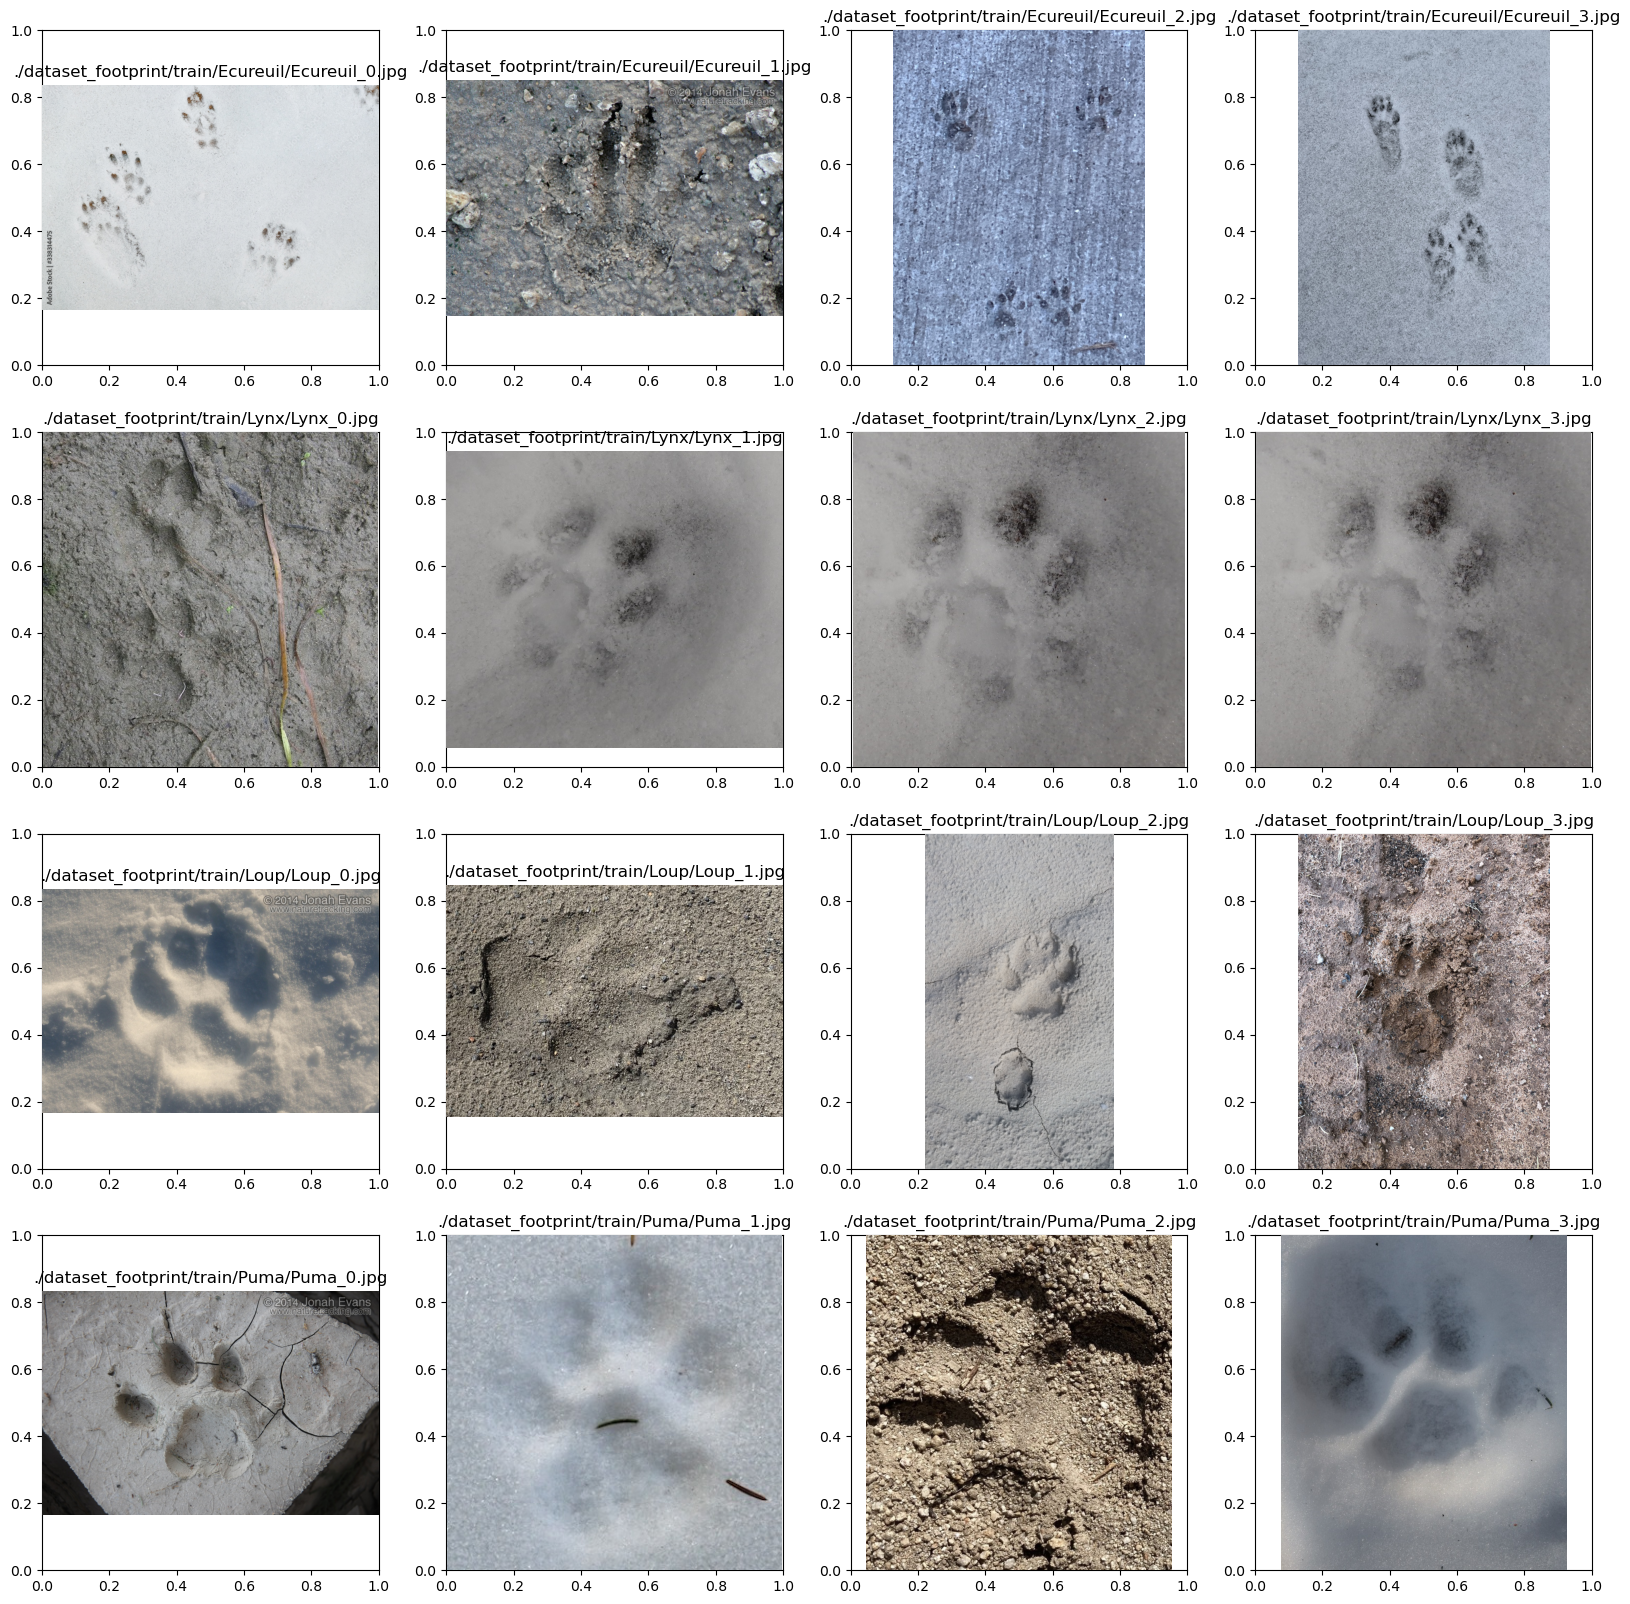

In [56]:
# Dossier source et categorie courante
sub_class = os.listdir(SRC_PATH_TRAIN)
print(sub_class)

## Il faudrait boucler sur les sub_class

# 1ere categorie d'animaux
#plt.figure(figsize=(10,5))
fig, ax = plt.subplots(4, 4, figsize=(20,20))
i = 0 # cadre d'image

categorie = sub_class[0]
print("Categorie :", categorie)
path = os.path.join(SRC_PATH_TRAIN, categorie)
print("Dossier :", path)
for k in range(4):
    lb_image = os.path.join(path, categorie+'_'+str(k)+'.jpg')
    img = plt.imread(lb_image)
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    ax.title.set_text(lb_image)
    ax.axis("off")
    i += 1

# 2nde categorie d'animaux
categorie = sub_class[1]
print("Categorie :", categorie)
path = os.path.join(SRC_PATH_TRAIN, categorie)
print("Dossier :", path)
for k in range(4):
    lb_image = os.path.join(path, categorie+'_'+str(k)+'.jpg')
    img = plt.imread(lb_image)
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    ax.title.set_text(lb_image)
    ax.axis("off")
    i += 1

# 3eme categorie d'animaux
categorie = sub_class[2]
print("Categorie :", categorie)
path = os.path.join(SRC_PATH_TRAIN,categorie)
print("Dossier :", path)
for k in range(4):
    lb_image = os.path.join(path, categorie+'_'+str(k)+'.jpg')
    img = plt.imread(lb_image)
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    ax.title.set_text(lb_image)
    ax.axis("off")
    i += 1


# 4eme categorie d'animaux
categorie = sub_class[3]
print("Categorie :", categorie)
path = os.path.join(SRC_PATH_TRAIN,categorie)
print("Dossier :", path)
for k in range(4):
    lb_image = os.path.join(path, categorie+'_'+str(k)+'.jpg')
    img = plt.imread(lb_image)
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    ax.title.set_text(lb_image)
    ax.axis("off")
    i += 1

plt.show()

In [57]:
IMG_SIZE = 160  # Taille de l'image IMG_SIZExIMG_SIZE (on augmente la resolution de 100 a 160)
BATCH_SIZE = 10  # nb de données à passer pour un A/R dans le réseau (total de 77 images x 3 classes)
NB_EPOCHS = 30  # Nb de passes

In [58]:
# Définition comme label les noms des sous-dossiers de travail
labels = os.listdir(SRC_PATH_TRAIN)
LST_DIR_LABELS = labels
LST_DIR_LABELS

['Ecureuil',
 'Lynx',
 'Loup',
 'Puma',
 'Chat',
 'Coyote',
 'Lapin',
 'Castor',
 'Rat',
 'RatonLaveur',
 'Chien',
 'Renard',
 'Ours']

In [59]:
# Sauvegarde du modèle optimal (nom et sous-dossier)
CKPT_NO, MDL_NAME = 'ckpt_footprints_1', '3footprints_CNN'
CKPT_DIR = './'+ CKPT_NO

Préparation des datasets

- **Initialisation de la classe ImageDataGenerator() de Keras :**

In [60]:
# Objet générateur de données de type images
# Séquence de transformation à appliquer à la volée : normalisation (taille d'image), rotation, zoom, ...
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2, 
        horizontal_flip=True,    
        rotation_range=20,
        width_shift_range=0.2,  # 0.05
        height_shift_range=0.2,
        #fill_mode="nearest",
        validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [61]:
# générateur qui définit à la volée des données à partir du jeu de données sources
train_generator = train_datagen.flow_from_directory(
    directory=SRC_PATH_TRAIN,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # binaire <=> vecteurs de proba, sparse <=> index de la classe, categorical
    #classes=LST_LABELS,
    subset='training',
    shuffle=True,
    seed=SEED_VALUE
)

labels = (train_generator.class_indices)
print(labels,'\n')

valid_generator = train_datagen.flow_from_directory(
    directory=SRC_PATH_TRAIN,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='sparse',   # "sparse",
    #classes=LST_LABELS,
    subset='validation',
    shuffle=True,
    seed=SEED_VALUE
)

test_generator = test_datagen.flow_from_directory(
    directory=SRC_PATH_TEST,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=1,
    class_mode='sparse',   #None,
    shuffle=False,
    seed=SEED_VALUE  # pas utile ici
)

Found 176 images belonging to 13 classes.


{'Castor': 0, 'Chat': 1, 'Chien': 2, 'Coyote': 3, 'Ecureuil': 4, 'Lapin': 5, 'Loup': 6, 'Lynx': 7, 'Ours': 8, 'Puma': 9, 'Rat': 10, 'RatonLaveur': 11, 'Renard': 12} 

Found 37 images belonging to 13 classes.
Found 52 images belonging to 13 classes.


# Construction du modèle et apprentissage des données

In [62]:
# Dictionnaire des labels contenus dans le jeu de données
DICT_LABELS = (train_generator.class_indices)
print(DICT_LABELS)

{'Castor': 0, 'Chat': 1, 'Chien': 2, 'Coyote': 3, 'Ecureuil': 4, 'Lapin': 5, 'Loup': 6, 'Lynx': 7, 'Ours': 8, 'Puma': 9, 'Rat': 10, 'RatonLaveur': 11, 'Renard': 12}


In [63]:
# Redéfinition des listes de labels (résultat identique attendu)
LST_LABELS = list(DICT_LABELS.keys())
print(LST_LABELS)

['Castor', 'Chat', 'Chien', 'Coyote', 'Ecureuil', 'Lapin', 'Loup', 'Lynx', 'Ours', 'Puma', 'Rat', 'RatonLaveur', 'Renard']


In [64]:
class_dictionary = train_generator.class_indices

DICT_IDX = {val:key for key,val in class_dictionary.items()}
DICT_IDX

{0: 'Castor',
 1: 'Chat',
 2: 'Chien',
 3: 'Coyote',
 4: 'Ecureuil',
 5: 'Lapin',
 6: 'Loup',
 7: 'Lynx',
 8: 'Ours',
 9: 'Puma',
 10: 'Rat',
 11: 'RatonLaveur',
 12: 'Renard'}

In [65]:
type(test_generator)

keras.preprocessing.image.DirectoryIterator

In [66]:
# Vérification conformité classes
test_generator.class_indices == train_generator.class_indices

True

In [67]:
# Liste des fichiers relatifs aux images de TEST
LST_TEST_FILENAMES = test_generator.filenames

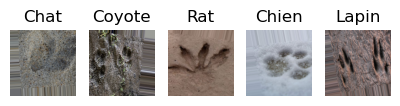

In [68]:
# Images générées dans le contexte des données d'apprentissage du modèle
images, labels = next(train_generator)
zipped = zip(images[0:5], labels[0:10])

# Balayage et Affichage
i = 0
plt.figure(figsize=(10,10))
for image, label in zipped:
    ax = plt.subplot(1,10, i + 1)
    i+=1
    plt.imshow(image)
    #plt.title(idx2fruit[list(label).index(1)], fontsize=12)
    plt.title(DICT_IDX[int(label)], fontsize=12)
    plt.axis("off")

Extrait des données construites à l'aide du générateur d'images du dataset d'inférence `TEST` :

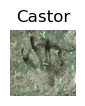

In [69]:
# Images générées (simplement normalisées) dans le contexte des données d'évaluation des performances du modèle en généralisation
images, labels = next(test_generator)
zipped = zip(images[0:5], labels[0:10])
# En fait, on ne génère qu'une image à la fois

# Balayage et Affichage
i = 0
plt.figure(figsize=(10,10))
for image, label in zipped:
    ax = plt.subplot(1,10, i + 1)
    i+=1
    plt.imshow(image)
    #plt.title(idx2fruit[list(label).index(1)], fontsize=12)
    plt.title(DICT_IDX[int(label)], fontsize=12)
    plt.axis("off")

* **Configuration complémentaire du traitement de construction du modèle et sélection du modèle optimal**

min_delta : variation minimale de la quantité contrôlée pour être considérée comme une c’est-à-dire un changement absolu de moins de min_delta, Ne comptent pas comme une amélioration.

patience : nombre d’époques sans après quoi la formation sera arrêtée.

In [70]:
PATH_BEST_MDL = CKPT_DIR + '/' + MDL_NAME
PATH_BEST_MDL

'./ckpt_footprints_1/3footprints_CNN'

In [77]:
# Prepare a directory to store all the checkpoints.
if not os.path.exists(CKPT_DIR):
    os.makedirs(CKPT_DIR)

# Configuration de keras_callbacks pour la sauvegarde du modèle optimal

# Configuration de l'arrêt anticipé par monitoring de la loss ou de l'accuracy (à expérimenter)
early_stopping  = EarlyStopping(monitor='val_loss', patience=10, mode='auto', min_delta=0, verbose=1)
#early_stopping  = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', min_delta=0, verbose=1)

keras_callbacks = [ModelCheckpoint(filepath=PATH_BEST_MDL,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='auto'),
                   early_stopping]

* **Entrainement du modele à partir de la fonction `fit()` :**

In [78]:
# Instanciation du modèle CNN
model = prepare_model()

# Compilation du modèle
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=['accuracy'])

# Apprentissage sur le dataset TRAIN avec confrontation des performances avec le sous-ensemble de VALidation (20%)
history = model.fit(train_generator, 
          validation_data=valid_generator,
          verbose=1,
          steps_per_epoch=train_generator.n//train_generator.batch_size,
          validation_steps=valid_generator.n//valid_generator.batch_size,
          epochs=NB_EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=[early_stopping]
        #   callbacks=keras_callbacks
)

Epoch 1/30


2024-08-09 16:21:13.827887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - ETA: 0s - loss: 2.6255 - accuracy: 0.0904

2024-08-09 16:21:17.870553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-08-09 16:21:18.486056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2024-08-09 16:21:18.598004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./ckpt_footprints_1/3footprints_CNN/assets


INFO:tensorflow:Assets written to: ./ckpt_footprints_1/3footprints_CNN/assets


17/17 [==============================] - 5s 295ms/step - loss: 2.6255 - accuracy: 0.0904 - val_loss: 2.5558 - val_accuracy: 0.1667
Epoch 2/30
17/17 [==============================] - 4s 203ms/step - loss: 2.5590 - accuracy: 0.1265 - val_loss: 2.5129 - val_accuracy: 0.1000
Epoch 3/30
17/17 [==============================] - 4s 205ms/step - loss: 2.5542 - accuracy: 0.1446 - val_loss: 2.5017 - val_accuracy: 0.1333
Epoch 4/30
17/17 [==============================] - 4s 204ms/step - loss: 2.5451 - accuracy: 0.1386 - val_loss: 2.5014 - val_accuracy: 0.1667
Epoch 5/30
17/17 [==============================] - 3s 197ms/step - loss: 2.5279 - accuracy: 0.1325 - val_loss: 2.4826 - val_accuracy: 0.1667
Epoch 6/30
17/17 [==============================] - 3s 196ms/step - loss: 2.5563 - accuracy: 0.1205 - val_loss: 2.5465 - val_accuracy: 0.1667
Epoch 7/30
17/17 [==============================] - 3s 192ms/step - loss: 2.5511 - accuracy: 0.0964 - val_loss: 2.5218 - val_accuracy: 0.1333
Epoch 8/30
17/17 

* **Représentation graphique des performances du modèle lors de sa construction**

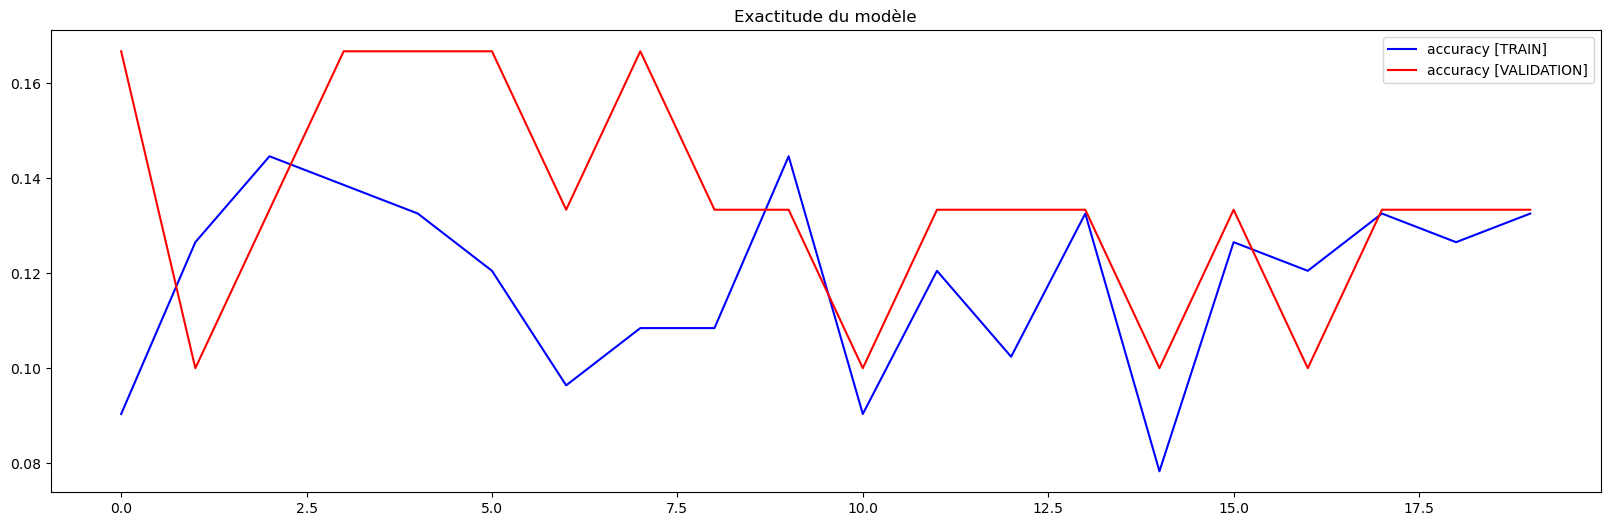

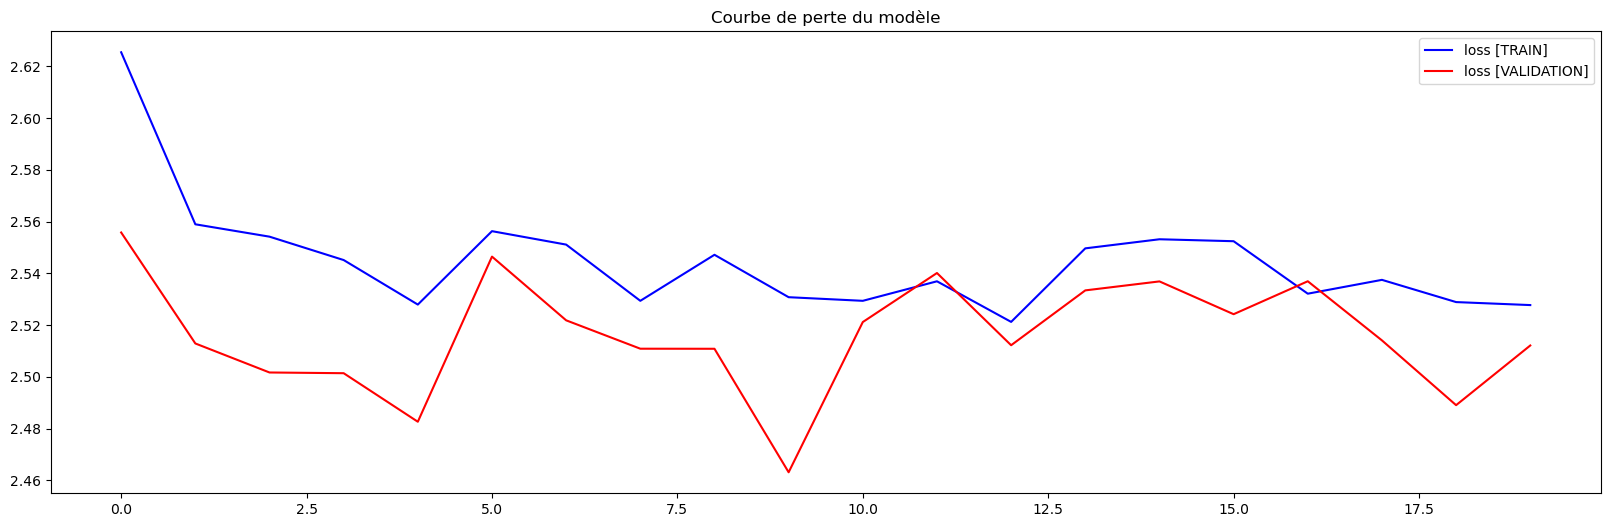

In [79]:
plot_learning_curve(history)

* **Chargement du meilleur modèle**

In [80]:
# Loading the automatically saved model
model_reloaded = load_model(CKPT_DIR + '/' + MDL_NAME)

# Saving the best model in the correct path and format
model_name_temp = os.path.join(CKPT_DIR, MDL_NAME + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(CKPT_DIR, MDL_NAME)
shutil.rmtree(folder_name_temp, ignore_errors=True)

# Le fichier de conf du modele a été sauvegardé puis rechargé dans la variable BEST_MODEL
BEST_MODEL = load_model(model_name_temp)

<a id='5'></a>
## 5. Evaluation globale et détaillée des performances du modèle optimal

[Début du notebook](#debut)

* **Evaluation globale des résultats du modèle : matrice de confusion et rapport de classification**

In [81]:
BEST_MODEL = model  # simple copie

 6/52 [==>...........................] - ETA: 0s

2024-08-09 16:24:08.587863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


52/52 [==============================] - 1s 16ms/step


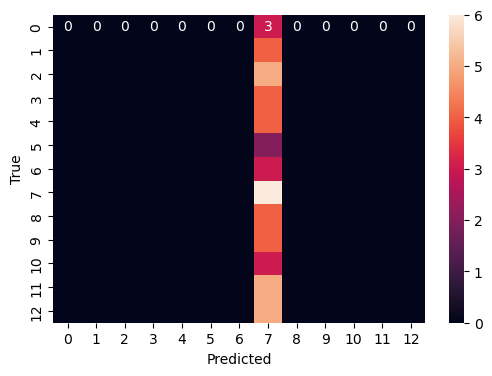

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         3
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000         5
           3      0.000     0.000     0.000         4
           4      0.000     0.000     0.000         4
           5      0.000     0.000     0.000         2
           6      0.000     0.000     0.000         3
           7      0.115     1.000     0.207         6
           8      0.000     0.000     0.000         4
           9      0.000     0.000     0.000         4
          10      0.000     0.000     0.000         3
          11      0.000     0.000     0.000         5
          12      0.000     0.000     0.000         5

    accuracy                          0.115        52
   macro avg      0.009     0.077     0.016        52
weighted avg      0.013     0.115     0.024        52



/Users/julesgribal/anaconda3/envs/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/julesgribal/anaconda3/envs/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/julesgribal/anaconda3/envs/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [82]:
# prediction
y_pred = BEST_MODEL.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# matrice de confusion
confusion_mtx = confusion_matrix(test_generator.classes, y_pred_classes)

# heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

# rapport de classification
print(classification_report(test_generator.classes, y_pred_classes, digits=3))

In [20]:
# Prepare a directory to store all the checkpoints.
if not os.path.exists(CKPT_DIR):
    os.makedirs(CKPT_DIR)

# Configuration de keras_callbacks pour la sauvegarde du modèle optimal

# Configuration de l'arrêt anticipé par monitoring de la loss ou de l'accuracy (à expérimenter)
#early_stopping  = EarlyStopping(monitor='val_loss', patience=5, mode='auto', min_delta=0, verbose=1)
early_stopping  = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', min_delta=0, verbose=1)

keras_callbacks = [ModelCheckpoint(filepath=PATH_BEST_MDL, 
                                   monitor='val_accuracy', 
                                   save_best_only=True, 
                                   mode='auto'),
                   early_stopping]

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=./ckpt_footprints_1/3footprints_CNN